In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt

c:\Users\annah\source\ArtificialIntelligence!-Python\github\AI-Anna-Holmstrom-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### 1.1 - Movielens full - EDA
Nu ska du ladda ned datasetet ml-latest.zip under sektionen "recommended for education and
development". Läs in dataseten "movies.csv" och "ratings.csv" besvara på följande frågorna nedan.

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

In [9]:
movies = "../../data/ml-latest/movies.csv"
ratings = "../../data/ml-latest/ratings.csv"

df_movies = pd.read_csv(movies, usecols=["movieId", "title", "genres"], dtype={"movieId":"int32","title":"str" })
df_ratings = pd.read_csv(ratings, usecols=["userId", "movieId", "rating"], dtype={"userId":"int32", "movieId":"int32", "rating":"float32"})

In [17]:
df_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
...,...,...,...
33832157,330975,8340,2.0
33832158,330975,8493,2.5
33832159,330975,8622,4.0
33832160,330975,8665,3.0


In [14]:
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [8]:
print(df_movies.shape)

(86537, 2)


In [13]:
df_ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
5,1,381,3.5
6,1,596,4.0
7,1,1036,5.0
8,1,1049,3.0
9,1,1066,4.0


In [12]:
print(df_ratings.shape)

(33832162, 3)


b) Vilka är de 10 filmerna med flest ratings?

In [40]:
# Count how many times each movieId appears in df_ratings
rating_counts = df_ratings["movieId"].value_counts()

# # Select 10 movies with the most ratings
movies = rating_counts.head(10)

#Select movies from df_movies that are among the top 10 most-rated using their movieId
top_10_titles = df_movies[df_movies["movieId"].isin(movies.index)].copy()

# Add column with number of ratings to top_10_titles
top_10_titles.loc[:,'Number of ratings'] = top_10_titles['movieId'].map(rating_counts)

# Sort by number of ratings
top_10_titles_sorted = top_10_titles.sort_values(by='Number of ratings', ascending=False)

# Change name of columns 
top_10_titles_sorted = top_10_titles_sorted.rename(columns={'title': 'Title'})

print(top_10_titles_sorted[['Title', 'Number of ratings']].to_string(index=False))

                                                Title  Number of ratings
                     Shawshank Redemption, The (1994)             122296
                                  Forrest Gump (1994)             113581
                                  Pulp Fiction (1994)             108756
                                   Matrix, The (1999)             107056
                     Silence of the Lambs, The (1991)             101802
            Star Wars: Episode IV - A New Hope (1977)              97202
                                    Fight Club (1999)              86207
                              Schindler's List (1993)              84232
                                 Jurassic Park (1993)              83026
Star Wars: Episode V - The Empire Strikes Back (1980)              80200


Stapeldiagram som visar antal ratings per film 

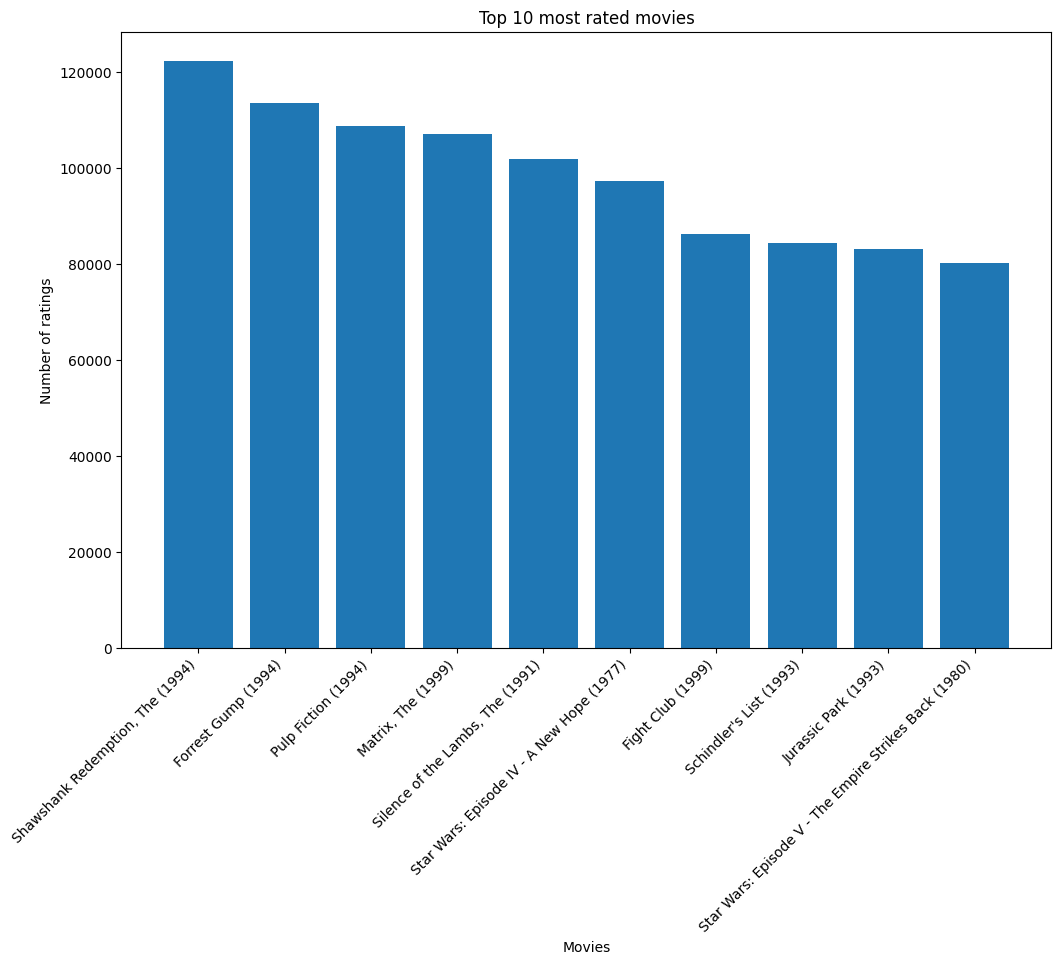

In [62]:
def plot_top_movies(dataframe, column, title='Top 10 Movies', ylabel='Value'):
    # Prepare data for plotting
    titles = dataframe['Title']
    values = dataframe[column]

    # Create a bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(titles, values)  # Create vertical bars
    plt.xlabel('Movies')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels and align them to the right
    plt.show()

plot_top_movies(top_10_titles_sorted, 'Number of ratings', 'Top 10 most rated movies', 'Number of ratings') 


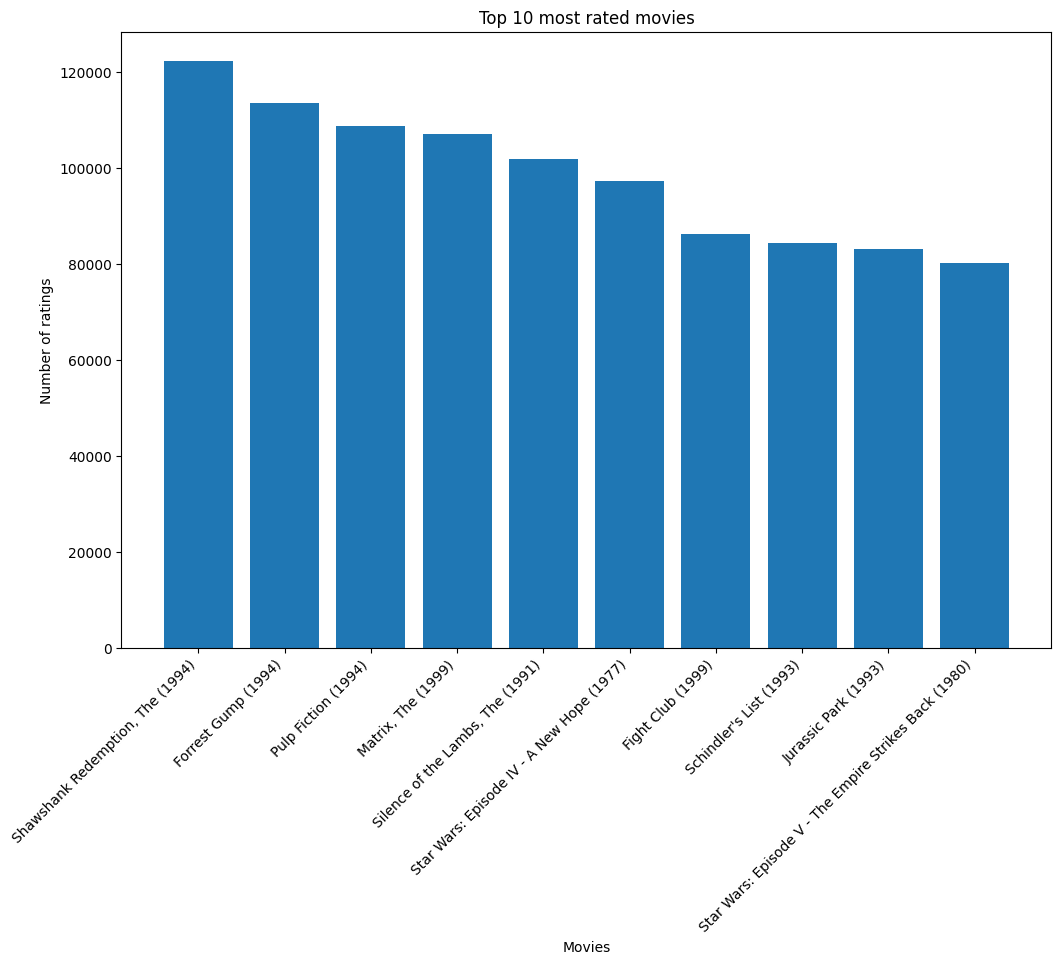

In [60]:
def plot_top_movies(dataframe, column, title='Top 10 Movies', ylabel='Value'):
    # Prepare data for plotting
    titles = dataframe['Title']
    values = dataframe[column]

    # Create a bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(titles, values)  # Create vertical bars
    plt.xlabel('Movies')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels and align them to the right
    plt.show()

plot_top_movies(top_10_titles_sorted, 'Number of ratings', 'Top 10 most rated movies', 'Number of ratings')

 c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [44]:
# Group df_ratings by movieId and calculate the mean rating for each movie
average_ratings = df_ratings.groupby('movieId')['rating'].mean()

# Add column Avarage Rating to sorted titles 
top_10_titles_sorted['Average Rating'] = top_10_titles_sorted['movieId'].map(average_ratings)

print(top_10_titles_sorted[['Title', 'Number of ratings', 'Average Rating']].to_string(index=False))

                                                Title  Number of ratings  Average Rating
                     Shawshank Redemption, The (1994)             122296        4.416792
                                  Forrest Gump (1994)             113581        4.068189
                                  Pulp Fiction (1994)             108756        4.191778
                                   Matrix, The (1999)             107056        4.160631
                     Silence of the Lambs, The (1991)             101802        4.150287
            Star Wars: Episode IV - A New Hope (1977)              97202        4.092401
                                    Fight Club (1999)              86207        4.236019
                              Schindler's List (1993)              84232        4.242337
                                 Jurassic Park (1993)              83026        3.689013
Star Wars: Episode V - The Empire Strikes Back (1980)              80200        4.118030
